In [19]:
import tensorflow as tf
import pandas as pd
import numpy as np
from surrogate import rules

from utils.df_loader import load_adult_df, load_compas_df, load_german_df, load_diabetes_df, load_breast_cancer_df
from utils.preprocessing import preprocess_df
from sklearn.model_selection import train_test_split
from utils.dice import generate_dice_result, process_results
from utils.models import train_three_models, evaluation_test, save_three_models, load_three_models
from utils.save import save_result_as_csv
from IPython.display import Image
import PIL
import pydotplus
from six import StringIO
from sklearn.tree import export_graphviz
from pydotplus import *


pd.options.mode.chained_assignment = None 

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

seed = 123
tf.random.set_seed(seed)
np.random.seed(seed)


TF version:  2.0.0
Eager execution enabled:  True


In [20]:
def get_location(scaler, col):
    if col in scaler.feature_names_in_:
        return np.where(scaler.feature_names_in_ == col)[0]
    
    else:
        raise Exception(f"Column [{col}] not a feature in this scaler, scaler features: {scaler.feature_names_in_}")


def get_scaled_value(scaler, col, X):
    loc=get_location(scaler, col)

    X *= scaler.scale_[loc]
    X += scaler.min_[loc]

    if scaler.clip:
        np.clip(X, scaler.feature_range[0][loc], scaler.feature_range[1][loc], out=X)
    
    return X[0]


def get_original_value(scaler, col, X):
    loc = get_location(scaler, col)

    X -= scaler.min_[loc]
    X /= scaler.scale_[loc]

    return X[0]

In [21]:
#### Select dataset ####'

dataset_name = 'adult' # [adult, german, compas]

if dataset_name == 'adult':
    dataset_loading_fn = load_adult_df
elif dataset_name == 'german':
    dataset_loading_fn = load_german_df
elif dataset_name == 'compas':
    dataset_loading_fn = load_compas_df
elif dataset_name == 'diabetes':
    dataset_loading_fn = load_diabetes_df
elif dataset_name == 'breast_cancer':
    dataset_loading_fn = load_breast_cancer_df
else:
    raise Exception("Unsupported dataset")

In [22]:
#### Load datafram info.
df_info = preprocess_df(dataset_loading_fn)
### Seperate to train and test set.
train_df, test_df = train_test_split(df_info.dummy_df, train_size=.8, random_state=seed, shuffle=True)
### Get training and testing array.
X_train = np.array(train_df[df_info.ohe_feature_names])
y_train = np.array(train_df[df_info.target_name])
X_test = np.array(test_df[df_info.ohe_feature_names])
y_test = np.array(test_df[df_info.target_name])
### Load models.
models = load_three_models(X_train.shape[-1], dataset_name)

In [23]:
#pip install pillow
#pip install dtreeviz
#pip install Graphviz
from dtreeviz.trees import *
from sklearn.tree import DecisionTreeClassifier
dice_dt = pd.read_csv(r'./datasets/eval_dice_adult_dt_result.csv')


In [24]:
dice_dt

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,scaled_input_age,scaled_input_workclass,scaled_input_education,scaled_input_marital-status,scaled_input_occupation,scaled_input_relationship,scaled_input_race,...,running_time,Found,ground_truth,prediction,L1,L2,Sparsity,Realistic,MAD,Mahalanobis
0,0.0,0.0,0.0,0.520548,State-gov,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,...,0.302225,Y,<=50K,<=50K,0.734150,0.734150,1.00,TRUE,2.371902,0.092499
1,1.0,0.0,0.0,0.520548,State-gov,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,...,0.346037,Y,<=50K,<=50K,1.000000,1.000000,1.00,TRUE,12.642901,0.073854
2,2.0,0.0,0.0,0.520548,State-gov,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,...,0.345071,Y,<=50K,<=50K,2.200000,1.428286,3.00,TRUE,2.548782,0.387717
3,3.0,0.0,0.0,0.520548,State-gov,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,...,0.348088,Y,<=50K,<=50K,0.838558,0.838558,1.00,TRUE,2.709223,0.105653
4,4.0,0.0,0.0,0.520548,State-gov,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,...,0.339086,Y,<=50K,<=50K,0.200000,0.200000,1.00,TRUE,2.528580,0.014771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,19.0,0.0,0.068493,Private,HS-grad,Widowed,Adm-clerical,Own-child,White,...,0.368978,Y,<=50K,<=50K,0.693142,0.601513,2.00,TRUE,3.180622,0.075671
97,97.0,19.0,0.0,0.068493,Private,HS-grad,Widowed,Adm-clerical,Own-child,White,...,0.343075,Y,<=50K,<=50K,0.700000,0.700000,1.00,TRUE,4.579421,0.064755
98,98.0,19.0,0.0,0.068493,Private,HS-grad,Widowed,Adm-clerical,Own-child,White,...,0.340083,Y,<=50K,<=50K,2.499286,1.499762,3.00,TRUE,0.834558,0.296088
99,99.0,19.0,0.0,0.068493,Private,HS-grad,Widowed,Adm-clerical,Own-child,White,...,0.370003,Y,<=50K,<=50K,2.000000,1.414214,2.00,TRUE,0.020202,0.174116


In [25]:
test1 = dice_dt.nsmallest(1,['L2'])
test1

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,scaled_input_age,scaled_input_workclass,scaled_input_education,scaled_input_marital-status,scaled_input_occupation,scaled_input_relationship,scaled_input_race,...,running_time,Found,ground_truth,prediction,L1,L2,Sparsity,Realistic,MAD,Mahalanobis
63,63.0,12.0,0.0,0.123288,Private,Some-college,Married-civ-spouse,Exec-managerial,Husband,White,...,0.373992,Y,<=50K,<=50K,0.17593,0.17593,1.0,TRUE,2.224263,0.012993


In [26]:
test = dice_dt.nlargest(1,['L2'])
test

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,scaled_input_age,scaled_input_workclass,scaled_input_education,scaled_input_marital-status,scaled_input_occupation,scaled_input_relationship,scaled_input_race,...,running_time,Found,ground_truth,prediction,L1,L2,Sparsity,Realistic,MAD,Mahalanobis
70,70.0,14.0,0.0,0.424658,Self-emp-not-inc,Some-college,Married-civ-spouse,Craft-repair,Husband,Amer-Indian-Eskimo,...,0.476494,Y,>50K,>50K,6.51186,2.484963,8.0,TRUE,1.0675,0.77604


In [27]:

# VISUALISE_DECISION_TREE_PATH
# 
def visualize_decision_tree_path( clf, graph, instance, indx, exp_type, path ):  

  for i, node in enumerate(graph.get_node_list()):
    if node.get_attributes().get('label') is None:
        continue

    if 'samples = ' in node.get_attributes()['label']:
        labels = node.get_attributes()['label'].split('<br/>')
        for i, label in enumerate(labels):
            if label.startswith('samples = '):
                labels[i] = 'samples = 0'
        node.set('label', '<br/>'.join(labels))
        node.set_fillcolor('white')
    
    lable_str = node.get_attributes()['label']  
    feature_value_str = (lable_str.split("<br/>")[0]).replace('<','')
    feature_name = feature_value_str.split(" ")[0]
    if feature_name in df_info.scaler.feature_names_in_:
      feature_value = float(feature_value_str.split(" ")[-1])
      original_value = get_original_value(df_info.scaler, feature_name , feature_value)
      #print(f"name: {feature_name}. value: {feature_value}, original_value: {original_value}")
      original_lable_str = lable_str.replace(feature_value_str, ' '.join([*(feature_value_str.split(' '))[:-1],f'{original_value:.2f}']))
      node.set('label', original_lable_str)
    #raise StopIteration()

  samples = instance
  
  decision_paths = clf.decision_path( [samples] )

  for decision_path in decision_paths:
    for n, node_value in enumerate(decision_path.toarray()[0]):
      if node_value == 0:
        continue
      node = graph.get_node(str(n))[0]            
      node.set_fillcolor('green')
      labels = node.get_attributes()['label'].split('<br/>')
      for i, label in enumerate(labels):
        if label.startswith('samples = '):
          labels[i] = 'samples = {}'.format(int(label.split('=')[1]) + 1)
      
      node.set('label', '<br/>'.join(labels))

  filename = path
  graph.write_png(filename)

  im = PIL.Image.open(filename)
  return im


# EXTRACT_DECISION_PATH
# 
def extract_decision_path(clf, graph, instance ):

  #samples = instance['scaled_vector']
  #decision_paths = clf.decision_path( [samples] )
  samples = instance
  decision_paths = clf.decision_path( [samples] )

  for decision_path in decision_paths:
    path = []
    for n, node_value in enumerate(decision_path.toarray()[0]):
      if node_value == 0:
        continue

      node = graph.get_node(str(n))[0]
      labels = node.get_attributes()['label'].split('<br/>')
      labels.pop(1)
      try:
        labels.remove("samples = 1")
        labels.remove("samples = 0")
        labels.remove("gini = 0.0")
      except ValueError:
        labels
      path.append(labels)
  return path

def export_decision_tree(clf, class_names, DATASET_NAME, path):
  dot_data = StringIO()
  export_graphviz(clf, out_file=dot_data,  
                  filled=True, rounded=True,
                  special_characters=True, feature_names = feature_names,
                  class_names=class_names)

  # convert to png format
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  graph.write_png(path)
  return graph


In [28]:
#### import evaluation function.
from utils.evaluation import prepare_evaluation_dict
input_and_cf = prepare_evaluation_dict(dice_dt, df_info)


clf=models['dt']
#clf = DecisionTreeClassifier()
class_names = ["No", "Yes"]



In [29]:
feature_names=df_info.ohe_feature_names
totoal_ohe_feature_names = len(feature_names)
totoal_ohe_feature_names

103

In [30]:
#filepath = PATH + 'Whitebox_Model/explanations/' + DATASET_NAME.replace(".csv", "")+ '/Decision_Tree/' + exp_type + '/decision_tree_general_' + str(INDX) + '.png'
PATH = "GitHub/Counterfactual-benchmark/"
dataset_name = 'adult' # [adult, german, compas]
filepath = "/Users/yu-liangchou/Desktop/cf_experiment/tree.png"
#feature_names=df_info.feature_names
feature_names=df_info.ohe_feature_names
graph = export_decision_tree(clf, class_names, dataset_name, filepath) 



#Image(graph.create_png())

InvocationException: Program terminated with status: 1. stderr follows: Error: not well-formed (invalid token) in line 1 
... <HTML>native-country_Trinadad&Tobago &le; 0.5 ...
in label of node 2312
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.224043 to fit


[Text(0.5960971399581521, 0.9912280701754386, 'node #0\nmarital-status_Married-civ-spouse <= 0.5\ngini = 0.365\nsamples = 26048\nvalue = [19793, 6255]'),
 Text(0.2440072253958557, 0.9736842105263158, 'node #1\ncapital-gain <= 0.071\ngini = 0.12\nsamples = 14056\nvalue = [13153, 903]'),
 Text(0.21188247146994182, 0.956140350877193, 'node #2\ncapital-loss <= 0.543\ngini = 0.092\nsamples = 13813\nvalue = [13145, 668]'),
 Text(0.15004782139442854, 0.9385964912280702, 'node #3\nhours-per-week <= 0.444\ngini = 0.087\nsamples = 13768\nvalue = [13137, 631]'),
 Text(0.0869157333999268, 0.9210526315789473, 'node #4\nage <= 0.226\ngini = 0.051\nsamples = 11115\nvalue = [10824, 291]'),
 Text(0.03110060057290547, 0.9035087719298246, 'node #5\nmarital-status_Married-AF-spouse <= 0.5\ngini = 0.014\nsamples = 6429\nvalue = [6383, 46]'),
 Text(0.02735825323041552, 0.8859649122807017, 'node #6\ncapital-loss <= 0.509\ngini = 0.013\nsamples = 6421\nvalue = [6378, 43]'),
 Text(0.02090849759242756, 0.868421

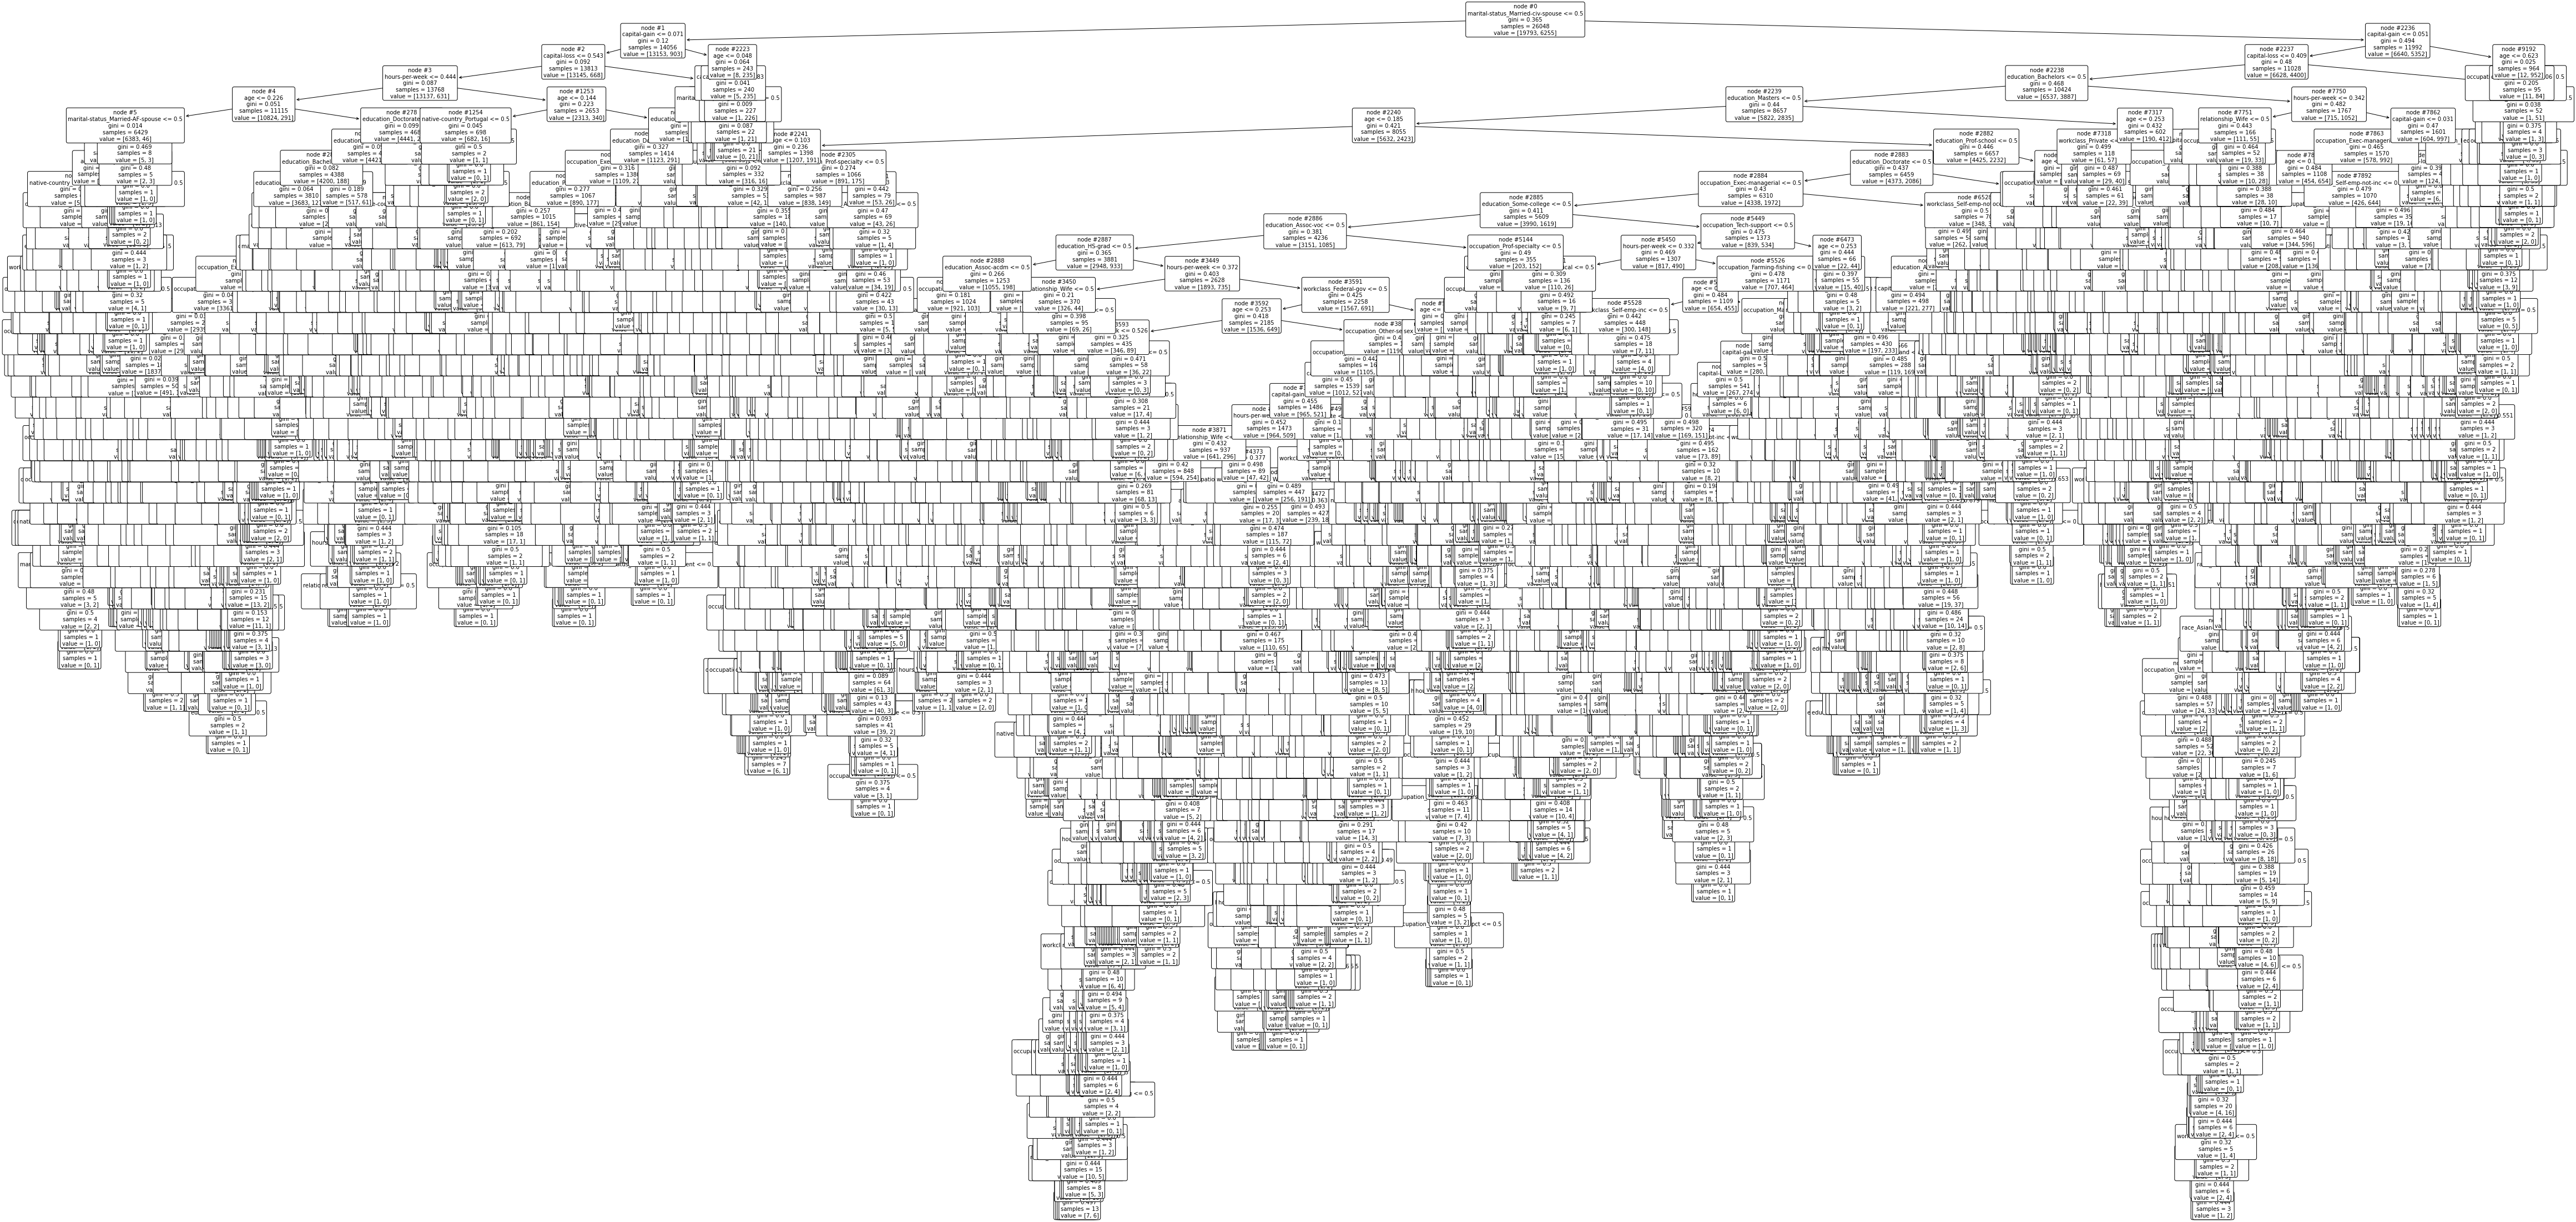

In [31]:
#### Plot the dt tree.
from sklearn import tree
import matplotlib.pyplot as plt
plt.figure(figsize=(80,40))
tree.plot_tree(models['dt'], fontsize=10, feature_names=df_info.ohe_feature_names, node_ids=True,rounded=True )
#If you need to colored the class >> filled=True


In [32]:
#### retrieve the input and cf vectors.
dice_input = input_and_cf['input'].loc[26]
dice_cf = input_and_cf['cf'].loc[26]





In [33]:
#### Present the decision path
tree_path = extract_decision_path(clf, graph, dice_input)
tree_path

NameError: name 'graph' is not defined

In [ ]:
INDX = 4
exp_type = "true_positives"
#instance = new_min_l2_instance_instance_arr

img = visualize_decision_tree_path( clf, export_decision_tree(clf, class_names, dataset_name, filepath), dice_input, INDX, 'true_positives', filepath)
img




In [ ]:
#exp_type = "L2_max"
INDX = 4
#instance = instance
#exp_type = "true_positives"
#instance = new_min_l2_instance_instance_arr

img = visualize_decision_tree_path( clf,  export_decision_tree(clf, class_names, dataset_name, filepath), dice_cf, INDX, 'true_positives', filepath)
img